# Introduction

This notebook analyzes whether it is possible through a simple machine learning model to predict whether  a trading will be positive or negative. The aim is to improve the current situation where 1 in 1.5 trades is negative. 

In [1]:
from backtest import get_hist, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades, \
                     backtester
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from sklearn.metrics import confusion_matrix

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Read Possible Trades

Read in 20k possible trades covering a three year period (2017 - 2020). They form the basis for the analysis and testing.

In [3]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
possible_trades_df = pd.read_csv(f'{DATAPATH}possible_trades_2000.csv')
possible_trades_df

,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,ticker
0,2018-08-10,7.20,2018-08-13,7.40,2.78,1,2.78,PIH
1,2018-08-20,7.10,2019-02-04,4.50,-36.62,114,-0.40,PIH
2,2019-04-03,5.23,2019-06-06,5.80,10.90,44,0.24,PIH
3,2019-06-28,4.95,2019-08-12,5.23,5.66,30,0.18,PIH
4,2019-09-09,4.97,2019-09-10,5.11,2.82,1,2.82,PIH
...,...,...,...,...,...,...,...,...
20911,2019-08-02,22.75,2019-10-11,31.19,37.10,49,0.65,ZUMZ
20912,2019-10-21,33.07,2019-11-05,32.63,-1.33,11,-0.12,ZUMZ
20913,2019-12-02,30.58,2019-12-20,31.86,4.19,14,0.29,ZUMZ
20914,2020-01-03,33.83,2020-01-10,33.78,-0.15,5,-0.03,ZUMZ


# Add Gain Column and Sum/Count

Add a column so we can see whether there is a gain or loss. This is done on a single share basis. The counts show that ratio of trades that add value to those that loose money is roughly 2 : 1. This is in line with heuristics that people quote in the news.

In [4]:
possible_trades_df['gain']=possible_trades_df.sell_close - possible_trades_df.buy_close

In [5]:
possible_trades_df['gain'][possible_trades_df.gain > 0].agg(['sum', 'count'])

sum      45384.9995
count    13858.0000
Name: gain, dtype: float64

In [6]:
possible_trades_df['gain'][possible_trades_df.gain < 0].agg(['sum', 'count'])

sum     -21083.3934
count     6786.0000
Name: gain, dtype: float64

In [7]:
possible_trades_df['gain'][possible_trades_df.gain == 0].agg(['sum', 'count'])

sum        0.0
count    272.0
Name: gain, dtype: float64

In [8]:
(13858 / ( 6786 + 272 + 13858))

0.6625549818320903

# Plot Trading Days vs Gain Percentage

The below chart visulaizes the distribution of trades over the range of possible percentage gains and losses versus the number of days a trade lasts. You can see that losses range from zero to hundred percent. On the other hand, the positive trades can go up to four hundred percent. The losses are limited in ac tual trades by using a stop-loss. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


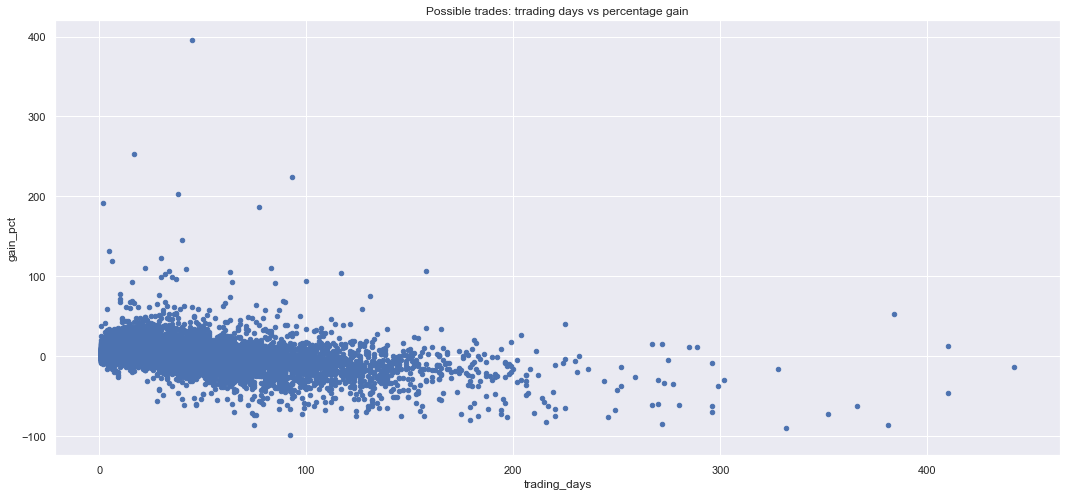

In [9]:
possible_trades_df.plot.scatter(x='trading_days', y='gain_pct', figsize=(18,8))
plt.title('Possible trades: trrading days vs percentage gain')
plt.show()

# Build Features for Balanced Scorecard

The cell below creates adds simple statistics per ticiker to the possible trades dataframe. It calculates per ticker the mean, standard deviation, minimum, and maximum. These are then merged into the possible trade dataframe using an inner join.

In [10]:
cols = ['ticker', 'trading_days', 'gain_pct', 'daily_return']
mean_df = possible_trades_df[cols].groupby('ticker').agg(['mean']).reset_index()
mean_df.columns=['ticker', 'mean_trading_days', 'mean_gain_pct', 'mean_daily_return']
possible_trades_df = pd.merge(possible_trades_df, mean_df, how='inner')

std_df = possible_trades_df[cols].groupby('ticker').agg(['std']).reset_index()
std_df.columns=['ticker', 'std_trading_days', 'std_gain_pct', 'std_daily_return']
possible_trades_df = pd.merge(possible_trades_df, std_df, how='inner')

std_df = possible_trades_df[cols].groupby('ticker').agg(['min']).reset_index()
std_df.columns=['ticker', 'min_trading_days', 'min_gain_pct', 'min_daily_return']
possible_trades_df = pd.merge(possible_trades_df, std_df, how='inner')

std_df = possible_trades_df[cols].groupby('ticker').agg(['max']).reset_index()
std_df.columns=['ticker', 'max_trading_days', 'max_gain_pct', 'max_daily_return']
possible_trades_df = pd.merge(possible_trades_df, std_df, how='inner')

# target = 1 for gains, zero otherwise
possible_trades_df['target'] = possible_trades_df.gain.apply(lambda x: 1 if x > 0 else 0)

possible_trades_df

,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,ticker,gain,mean_trading_days,...,std_trading_days,std_gain_pct,std_daily_return,min_trading_days,min_gain_pct,min_daily_return,max_trading_days,max_gain_pct,max_daily_return,target
0,2018-08-10,7.20,2018-08-13,7.40,2.78,1,2.78,PIH,0.20,23.666667,...,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
1,2018-08-20,7.10,2019-02-04,4.50,-36.62,114,-0.40,PIH,-2.60,23.666667,...,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,0
2,2019-04-03,5.23,2019-06-06,5.80,10.90,44,0.24,PIH,0.57,23.666667,...,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
3,2019-06-28,4.95,2019-08-12,5.23,5.66,30,0.18,PIH,0.28,23.666667,...,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
4,2019-09-09,4.97,2019-09-10,5.11,2.82,1,2.82,PIH,0.14,23.666667,...,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20911,2019-08-02,22.75,2019-10-11,31.19,37.10,49,0.65,ZUMZ,8.44,23.937500,...,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,1
20912,2019-10-21,33.07,2019-11-05,32.63,-1.33,11,-0.12,ZUMZ,-0.44,23.937500,...,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,0
20913,2019-12-02,30.58,2019-12-20,31.86,4.19,14,0.29,ZUMZ,1.28,23.937500,...,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,1
20914,2020-01-03,33.83,2020-01-10,33.78,-0.15,5,-0.03,ZUMZ,-0.05,23.937500,...,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,0


In [11]:
possible_trades_df.columns

Index(['buy_date', 'buy_close', 'sell_date', 'sell_close', 'gain_pct',
       'trading_days', 'daily_return', 'ticker', 'gain', 'mean_trading_days',
       'mean_gain_pct', 'mean_daily_return', 'std_trading_days',
       'std_gain_pct', 'std_daily_return', 'min_trading_days', 'min_gain_pct',
       'min_daily_return', 'max_trading_days', 'max_gain_pct',
       'max_daily_return', 'target'],
      dtype='object')

# Convert Buy Date to a Counter

The balanced scorecard does not work with datetime objects, and hence the date is is converted to a simple integere starting from zero on the earliest day, and then counts up.

In [12]:
possible_trades_df = possible_trades_df.rename(columns={'buy_date': 'buy_date_orig'})

possible_trades_df['buy_date'] = \
    pd.to_datetime(possible_trades_df.buy_date_orig, infer_datetime_format=True) - \
    pd.to_datetime(possible_trades_df.buy_date_orig, infer_datetime_format=True).min()

possible_trades_df.buy_date = (possible_trades_df.buy_date.astype('int')/86400000000000).astype('int')
print(possible_trades_df.columns)
possible_trades_df.buy_date.describe()

Index(['buy_date_orig', 'buy_close', 'sell_date', 'sell_close', 'gain_pct',
       'trading_days', 'daily_return', 'ticker', 'gain', 'mean_trading_days',
       'mean_gain_pct', 'mean_daily_return', 'std_trading_days',
       'std_gain_pct', 'std_daily_return', 'min_trading_days', 'min_gain_pct',
       'min_daily_return', 'max_trading_days', 'max_gain_pct',
       'max_daily_return', 'target', 'buy_date'],
      dtype='object')


count    20916.000000
mean       510.144005
std        304.129305
min          0.000000
25%        251.000000
50%        510.000000
75%        776.000000
max       1069.000000
Name: buy_date, dtype: float64

# Create Data Set for Balanced Scorecard

Take out the columns that are derivatives of target from possible trades dataframe and store it in a new data frame: data.

In [13]:
used_cols    = [ 'buy_date', 'trading_days', 
                'mean_trading_days', 'mean_gain_pct', 'mean_daily_return',
                'std_trading_days', 'std_gain_pct', 'std_daily_return',
                'min_trading_days', 'min_gain_pct', 'min_daily_return',
                'max_trading_days', 'max_gain_pct', 'max_daily_return',
               ]
target       ='target'
data         = possible_trades_df[used_cols]
data[target] = possible_trades_df[target]
data

,buy_date,trading_days,mean_trading_days,mean_gain_pct,mean_daily_return,std_trading_days,std_gain_pct,std_daily_return,min_trading_days,min_gain_pct,min_daily_return,max_trading_days,max_gain_pct,max_daily_return,target
0,505,1,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
1,515,114,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,0
2,741,44,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
3,827,30,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
4,900,1,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20911,862,49,23.937500,5.846875,0.613750,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,1
20912,942,11,23.937500,5.846875,0.613750,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,0
20913,984,14,23.937500,5.846875,0.613750,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,1
20914,1016,5,23.937500,5.846875,0.613750,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,0


# Get Rid Off NaN

Drop the NaN from the data dataframe. There are only 69 rows and the data set is over 20k rows, so we delete the NaNs.

In [14]:
data.isna().sum()

buy_date              0
trading_days          0
mean_trading_days     0
mean_gain_pct         0
mean_daily_return     0
std_trading_days     69
std_gain_pct         69
std_daily_return     69
min_trading_days      0
min_gain_pct          0
min_daily_return      0
max_trading_days      0
max_gain_pct          0
max_daily_return      0
target                0
dtype: int64

In [15]:
data = data.dropna()
data.isna().sum()

buy_date             0
trading_days         0
mean_trading_days    0
mean_gain_pct        0
mean_daily_return    0
std_trading_days     0
std_gain_pct         0
std_daily_return     0
min_trading_days     0
min_gain_pct         0
min_daily_return     0
max_trading_days     0
max_gain_pct         0
max_daily_return     0
target               0
dtype: int64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20847 entries, 0 to 20915
Data columns (total 15 columns):
buy_date             20847 non-null int64
trading_days         20847 non-null int64
mean_trading_days    20847 non-null float64
mean_gain_pct        20847 non-null float64
mean_daily_return    20847 non-null float64
std_trading_days     20847 non-null float64
std_gain_pct         20847 non-null float64
std_daily_return     20847 non-null float64
min_trading_days     20847 non-null int64
min_gain_pct         20847 non-null float64
min_daily_return     20847 non-null float64
max_trading_days     20847 non-null int64
max_gain_pct         20847 non-null float64
max_daily_return     20847 non-null float64
target               20847 non-null int64
dtypes: float64(10), int64(5)
memory usage: 2.5 MB


# Create Balanced Scorecard Pipe

Implement a weight of eviden ce balanced scorecard.

In [17]:
encoder   = WOEEncoder()
binner    = KBinsDiscretizer(n_bins=5, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
imputer   = SimpleImputer(strategy='constant', fill_value=0.0)
clf       = LogisticRegression(class_weight='balanced', random_state=42)

pipe = make_pipeline(binner, objectify, encoder, imputer, clf)

# Get Data Ready for Balanced Scorecard

Basically create X with the features and y with the target.

In [18]:
# cross validate after initializing X and y
used_cols = [c for c in data.columns.tolist() if c not in [target]]
data[target] = data[target].apply(lambda x: 1 if x == 1 else 0)
X, y = data[used_cols].values, data[target].values

In [19]:
used_cols

['buy_date',
 'trading_days',
 'mean_trading_days',
 'mean_gain_pct',
 'mean_daily_return',
 'std_trading_days',
 'std_gain_pct',
 'std_daily_return',
 'min_trading_days',
 'min_gain_pct',
 'min_daily_return',
 'max_trading_days',
 'max_gain_pct',
 'max_daily_return']

# Run Balanced Scorecard

Run the balanced scorecard with two measures: accuracy and AUC. The accuracy is the most important measure here. As that is ultimately what you care about. The balanced scorecard accuracy is basically the same as the naive baseline of predicting 1 (in which case you would be right 66 percent of the times.) So, the features only add about one percent (and that may well be due to randomness.)

In [20]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

In [21]:
print("mean cross_val_score=", scores.mean(), "std cross_val_score=", scores.std())

mean cross_val_score= 0.6736228977959393 std cross_val_score= 0.009265176963059668


In [22]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')

In [23]:
print("mean cross_val_score=", scores.mean(), "std cross_val_score=", scores.std())

mean cross_val_score= 0.7337503824870824 std cross_val_score= 0.008497909748035205


# Split Data into Training and Test Data

To work with confusion matrices below, we need to split the data into training and test. The percentage of training data is in line with what is used for the local minima and maxima models. 

In [24]:
X, y, X_train, X_test, y_train, y_test = split_data(data, used_cols, target, 0.7)

# Helper Function to Print Confusion Matrix Statistics

The cell below is a simple helper function that prints basic confusion matrix statistics.

In [25]:
# y_train & y_test are not parameters and are taken from globals namespace

def print_stats(pipe, target, train_preds, test_preds):
    print("TRAIN CONFUSION MATRIX:")
    print(confusion_matrix(y_train, train_preds))
    print('')
    
    
    print("TEST CONFUSION MATRIX:")
    print(confusion_matrix(y_test, test_preds), "\n")
    
    print("Accuracy:"); print("="*len("Accuracy:"))
    print("TRAIN:", accuracy_score(y_train, train_preds))
    print("TEST:", accuracy_score(y_test, test_preds), "\n")
    
    train_preds = pipe.predict_proba(X_train)[:,1]
    test_preds = pipe.predict_proba(X_test)[:,1]

    print("AUC:"); print("="*len("AUC:"))
    print("TRAIN:", roc_auc_score(y_train, train_preds))
    print("TEST:", roc_auc_score(y_test, test_preds), "\n")
    
    scores = cross_val_score(pipe, X, y.values, cv=5, scoring='accuracy')
    print("Cross validation:", scores.mean(), "+/-", scores.std(), "\n")
    
    coeffs = pipe['logisticregression'].coef_
    print("coef_=", coeffs, "\n")
    
    key = [np.abs(coeffs) > 0]
    display(pd.DataFrame(X.columns).iloc[key[0][0]])

# Call The Confusiuon Matrix Helper Function

The Helper function prints the confusion matrix for training and testing data, as well as the coefficients used by the logistic regression model (of the balanced scorecard).

In [26]:
pipe.fit(X_train, y_train.values)

train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

print_stats(pipe, target, train_preds, test_preds)

TRAIN CONFUSION MATRIX:
[[3151 1761]
 [3016 6664]]

TEST CONFUSION MATRIX:
[[1372  750]
 [1223 2910]] 

Accuracy:
TRAIN: 0.6726288377192983
TEST: 0.6845723421262989 

AUC:
====
TRAIN: 0.7319116449511401
TEST: 0.7429459058409669 

Cross validation: 0.6736228977959393 +/- 0.009265176963059668 

coef_= [[ 0.7603312   1.06723988 -0.52290192  0.65466288  0.72026825 -1.05654829
   0.21037919  0.65923226  0.54355196  0.03142252  0.63373065 -0.69857888
   0.280047   -0.08724647]] 



,0
0,buy_date
1,trading_days
2,mean_trading_days
3,mean_gain_pct
4,mean_daily_return
5,std_trading_days
6,std_gain_pct
7,std_daily_return
8,min_trading_days
9,min_gain_pct


# Get the True Positive Rate (TPR)

The cell below prints the test confusion matrix along with the true positive rate (TPR). We care about the TPR because if we can predict the probability of going up that is better than the naive prediction, we reduce the number of times that the stock goes down. The only caution is that this is only one sample, and we would need to run it over multiple periods to get a sense of how well it does. Note that accuracy is NOT the same as TPR. Accuracy is (TN + TP) / (TN + FN + TP + FP) while TPR is TP/(FN+TP).

Note that one of the reasons the model is doing well in determining TPR is that the moxdel is using number of days in trade which is not known up front. This intuitively makes sense as the longer a trade lasts, the more risky it typically is.

In [27]:
conf_mat = confusion_matrix(y_test, test_preds)
tn, fn, fp, tp = conf_mat.ravel()
print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
print('')
print(conf_mat)
print('')
print("TP/(FN+TP)=", tp/(fn + tp), "FN+TP=", fn+tp)

tn= 1372 fn= 750 tp= 2910 fp= 1223

[[1372  750]
 [1223 2910]]

TP/(FN+TP)= 0.7950819672131147 FN+TP= 3660


# Range of Predicted Probabilities

Check for the range of predicted probabilities. This is a good spread.

In [28]:
print(min((pipe.predict_proba(X_train))[:, 1]), 
      max((pipe.predict_proba(X_train))[:, 1]))

0.0517991887865682 0.9175893280316666


# Helper Function to Print Confusion Matrix and TPR

That avoids us having to manually calculate the TPR and confusion matrices. Threshold can be used to increase TPR at the expense of TNR (true negative rate).

In [29]:
# X_train, X_test, y_train, y_test are accessed in global namespace

def print_confusion_matrix(threshold):
    train_preds_probs = (pipe.predict_proba(X_train) > threshold).astype(int)[:,1]
    test_preds_probs = (pipe.predict_proba(X_test)  > threshold).astype(int)[:,1]

    print("len(X_train)=", len(X_train))
    print("len(X_test)=", len(X_test))
    print("len(train_preds_probs)=", len(train_preds_probs), "sum=", sum(train_preds_probs))
    print("len(y_train)=", len(y_train), "sum=", sum(y_train), "\n")
    print("len(test_preds_probs)=", len(test_preds_probs),  "sum=", sum(test_preds_probs))
    print("len(y_test)=", len(y_test), "sum=", sum(y_test), "\n")

    print("TRAIN CONFUSION MATRIX:")
    train_conf_m = confusion_matrix(y_train, train_preds_probs)
    tn, fn, fp, tp = train_conf_m.ravel()
    print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
    print(train_conf_m)
    print("TP/(FN+TP)=", tp/(fn + tp), "FN+TP=", fn+tp)
    print("share of data=", (tp + fn)/(tp+fp+tn+fn) )

    print('')

    print("TEST CONFUSION MATRIX:")
    test_conf_m = confusion_matrix(y_test, test_preds_probs)
    tn, fn, fp, tp = test_conf_m.ravel()
    print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
    print(test_conf_m, "\n")
    print("TP/(FN+TP)=", tp/(fn + tp), "FN+TP=", fn+tp)
    print("share of data=", (tp + fn)/(tp+fp+tn+fn) )
    
    return test_preds_probs

In [30]:
print_confusion_matrix(0.5)

len(X_train)= 14592
len(X_test)= 6255
len(train_preds_probs)= 14592 sum= 8425
len(y_train)= 14592 sum= 9680 

len(test_preds_probs)= 6255 sum= 3660
len(y_test)= 6255 sum= 4133 

TRAIN CONFUSION MATRIX:
tn= 3151 fn= 1761 tp= 6664 fp= 3016
[[3151 1761]
 [3016 6664]]
TP/(FN+TP)= 0.7909792284866469 FN+TP= 8425
share of data= 0.5773711622807017

TEST CONFUSION MATRIX:
tn= 1372 fn= 750 tp= 2910 fp= 1223
[[1372  750]
 [1223 2910]] 

TP/(FN+TP)= 0.7950819672131147 FN+TP= 3660
share of data= 0.5851318944844125


array([0, 0, 0, ..., 1, 1, 1])

In [31]:
print_confusion_matrix(0.8)

len(X_train)= 14592
len(X_test)= 6255
len(train_preds_probs)= 14592 sum= 1069
len(y_train)= 14592 sum= 9680 

len(test_preds_probs)= 6255 sum= 500
len(y_test)= 6255 sum= 4133 

TRAIN CONFUSION MATRIX:
tn= 4820 fn= 92 tp= 977 fp= 8703
[[4820   92]
 [8703  977]]
TP/(FN+TP)= 0.9139382600561272 FN+TP= 1069
share of data= 0.0732593201754386

TEST CONFUSION MATRIX:
tn= 2079 fn= 43 tp= 457 fp= 3676
[[2079   43]
 [3676  457]] 

TP/(FN+TP)= 0.914 FN+TP= 500
share of data= 0.07993605115907274


array([0, 0, 0, ..., 1, 0, 0])

# Replace Trading Days with the Mean Trading Days

The cells below modify the test data and copy over the mean trading days per ticker into the trading_days column. This is done to see how the model does on this, as we don't know the trading days in advance. The data frame is call `new_data` to distinguish it from data itself. We expect it to perform less than the results on data itself.

In [32]:
starting_at = int(len(data)*0.7)
starting_at

14592

In [33]:
new_data = data
new_data.trading_days.iloc[starting_at:] = new_data.mean_trading_days.iloc[starting_at:]
new_data

,buy_date,trading_days,mean_trading_days,mean_gain_pct,mean_daily_return,std_trading_days,std_gain_pct,std_daily_return,min_trading_days,min_gain_pct,min_daily_return,max_trading_days,max_gain_pct,max_daily_return,target
0,505,1.0000,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
1,515,114.0000,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,0
2,741,44.0000,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
3,827,30.0000,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
4,900,1.0000,23.666667,-1.451111,0.706667,36.993243,13.724030,1.239526,1,-36.62,-0.45,114,10.9,2.82,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20911,862,23.9375,23.937500,5.846875,0.613750,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,1
20912,942,23.9375,23.937500,5.846875,0.613750,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,0
20913,984,23.9375,23.937500,5.846875,0.613750,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,1
20914,1016,23.9375,23.937500,5.846875,0.613750,25.678704,14.064353,1.170145,1,-19.42,-0.53,101,37.1,4.69,0


# Create Predictions for New Data

In [34]:
X, y, X_train, X_test, y_train, y_test = split_data(new_data, used_cols, target, 0.7)

In [35]:
pipe.fit(X_train, y_train.values)

train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

print_stats(pipe, target, train_preds, test_preds)

TRAIN CONFUSION MATRIX:
[[3151 1761]
 [3016 6664]]

TEST CONFUSION MATRIX:
[[ 743 1379]
 [ 865 3268]] 

Accuracy:
TRAIN: 0.6726288377192983
TEST: 0.6412470023980815 

AUC:
====
TRAIN: 0.7319116449511401
TEST: 0.6179000404322534 

Cross validation: 0.6494937338687456 +/- 0.004580177733878434 

coef_= [[ 0.7603312   1.06723988 -0.52290192  0.65466288  0.72026825 -1.05654829
   0.21037919  0.65923226  0.54355196  0.03142252  0.63373065 -0.69857888
   0.280047   -0.08724647]] 



,0
0,buy_date
1,trading_days
2,mean_trading_days
3,mean_gain_pct
4,mean_daily_return
5,std_trading_days
6,std_gain_pct
7,std_daily_return
8,min_trading_days
9,min_gain_pct


# Calculate New Data's TPR

Calculate new data's TPR for different thresholds. You can see that we need to increase threshold to around 0.7 to get the same result as the TPR for data with a threshold of 0.5. Doing so, reduces the number of trades we let through and also reduces the potential upside. So, the model is unlikely to work in practice as we seem to be throwing the baby out of the bath with the water... The plots visualize what is happening.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


len(X_train)= 14592
len(X_test)= 6255
len(train_preds_probs)= 14592 sum= 8425
len(y_train)= 14592 sum= 9680 

len(test_preds_probs)= 6255 sum= 4647
len(y_test)= 6255 sum= 4133 

TRAIN CONFUSION MATRIX:
tn= 3151 fn= 1761 tp= 6664 fp= 3016
[[3151 1761]
 [3016 6664]]
TP/(FN+TP)= 0.7909792284866469 FN+TP= 8425
share of data= 0.5773711622807017

TEST CONFUSION MATRIX:
tn= 743 fn= 1379 tp= 3268 fp= 865
[[ 743 1379]
 [ 865 3268]] 

TP/(FN+TP)= 0.7032494082203572 FN+TP= 4647
share of data= 0.7429256594724221

up_count=3268 70.32 %
down_count=1327 28.56 %
zero_count=1327 1.12 %


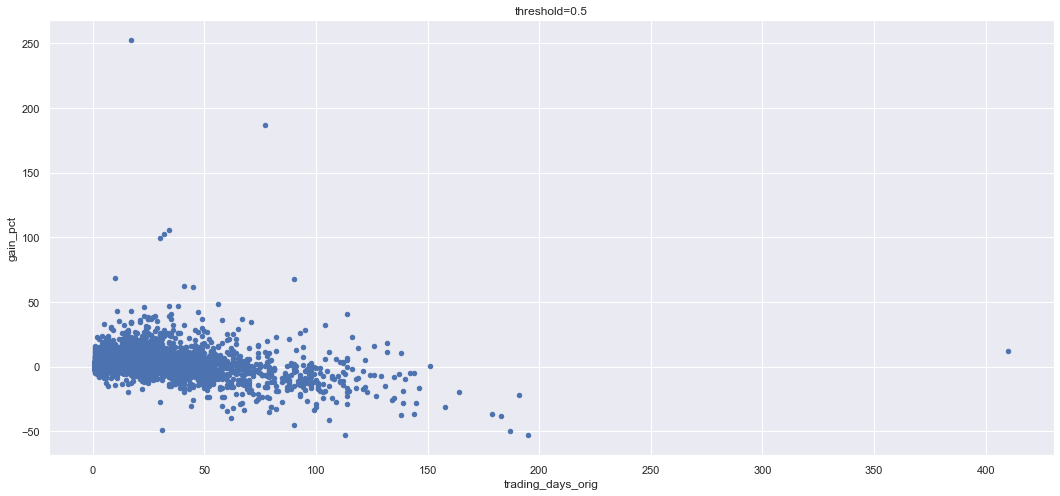

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


len(X_train)= 14592
len(X_test)= 6255
len(train_preds_probs)= 14592 sum= 5915
len(y_train)= 14592 sum= 9680 

len(test_preds_probs)= 6255 sum= 3646
len(y_test)= 6255 sum= 4133 

TRAIN CONFUSION MATRIX:
tn= 3903 fn= 1009 tp= 4906 fp= 4774
[[3903 1009]
 [4774 4906]]
TP/(FN+TP)= 0.8294167371090448 FN+TP= 5915
share of data= 0.40535910087719296

TEST CONFUSION MATRIX:
tn= 1122 fn= 1000 tp= 2646 fp= 1487
[[1122 1000]
 [1487 2646]] 

TP/(FN+TP)= 0.7257268239166209 FN+TP= 3646
share of data= 0.5828936850519585

up_count=2646 72.57 %
down_count=966 26.49 %
zero_count=966 0.93 %


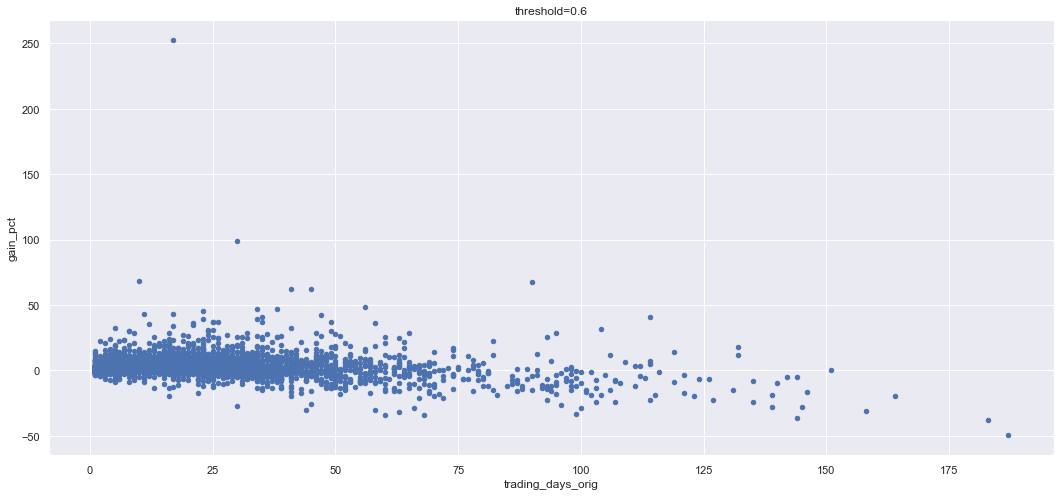

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


len(X_train)= 14592
len(X_test)= 6255
len(train_preds_probs)= 14592 sum= 3254
len(y_train)= 14592 sum= 9680 

len(test_preds_probs)= 6255 sum= 2175
len(y_test)= 6255 sum= 4133 

TRAIN CONFUSION MATRIX:
tn= 4490 fn= 422 tp= 2832 fp= 6848
[[4490  422]
 [6848 2832]]
TP/(FN+TP)= 0.8703134603564844 FN+TP= 3254
share of data= 0.22299890350877194

TEST CONFUSION MATRIX:
tn= 1592 fn= 530 tp= 1645 fp= 2488
[[1592  530]
 [2488 1645]] 

TP/(FN+TP)= 0.7563218390804598 FN+TP= 2175
share of data= 0.34772182254196643

up_count=1645 75.63 %
down_count=515 23.68 %
zero_count=515 0.69 %


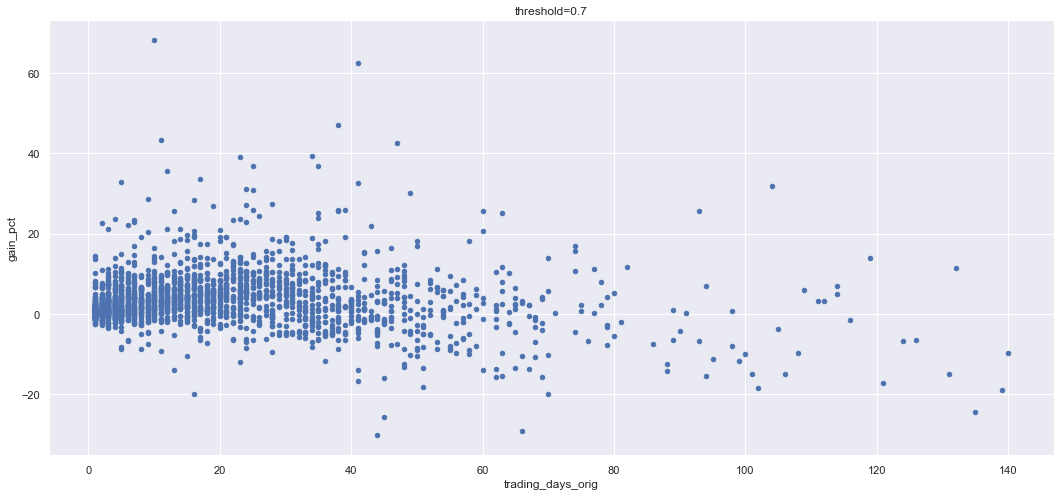

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


len(X_train)= 14592
len(X_test)= 6255
len(train_preds_probs)= 14592 sum= 1069
len(y_train)= 14592 sum= 9680 

len(test_preds_probs)= 6255 sum= 507
len(y_test)= 6255 sum= 4133 

TRAIN CONFUSION MATRIX:
tn= 4820 fn= 92 tp= 977 fp= 8703
[[4820   92]
 [8703  977]]
TP/(FN+TP)= 0.9139382600561272 FN+TP= 1069
share of data= 0.0732593201754386

TEST CONFUSION MATRIX:
tn= 2034 fn= 88 tp= 419 fp= 3714
[[2034   88]
 [3714  419]] 

TP/(FN+TP)= 0.8264299802761341 FN+TP= 507
share of data= 0.08105515587529977

up_count=419 82.64 %
down_count=87 17.16 %
zero_count=87 0.2 %


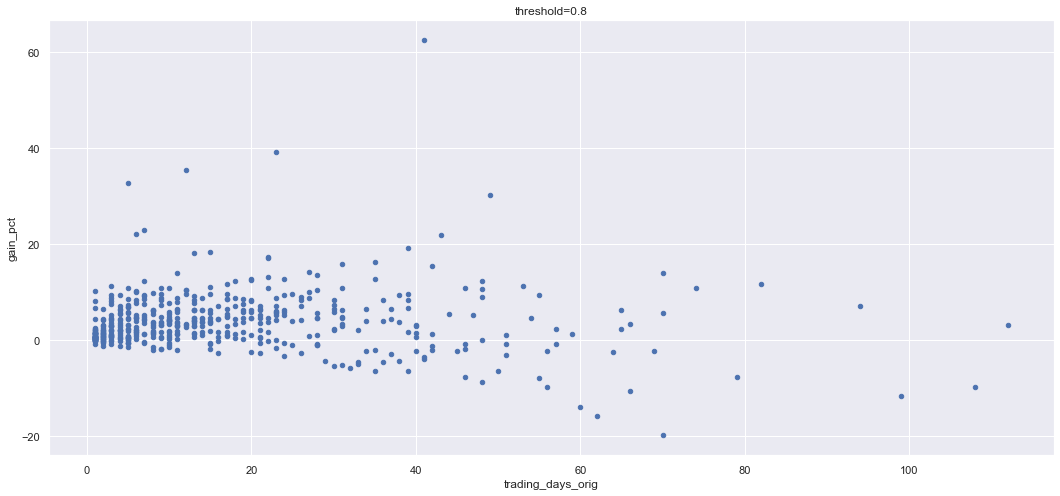

In [39]:
thresholds = [0.5, 0.6, 0.7, 0.8]

for t in thresholds:

    test_preds_probs = print_confusion_matrix(t)
    
    new_data['pred'] = new_data[target]
    new_data.pred.iloc[starting_at:] = test_preds_probs

    new_data['gain_pct'] = possible_trades_df['gain_pct']
    new_data['trading_days_orig'] = possible_trades_df['trading_days']

    new_test_data = new_data.iloc[starting_at:]
    new_test_data = new_test_data.loc[new_test_data.pred == 1]
    
    idx = new_test_data.gain_pct > 0
    up_count = new_test_data.loc[idx].count()[0]
    
    idx = new_test_data.gain_pct < 0
    down_count = new_test_data.loc[idx].count()[0]
    
    idx = new_test_data.gain_pct == 0
    zero_count = new_test_data.loc[idx].count()[0]
    
    print(f'\nup_count={up_count} {round((up_count/(up_count+down_count+zero_count))*100,2)} %')
    print(f'down_count={down_count} {round((down_count/(up_count+down_count+zero_count))*100,2)} %')
    print(f'zero_count={down_count} {round((zero_count/(up_count+down_count+zero_count))*100,2)} %')
    
    
    new_test_data.plot.scatter(x='trading_days_orig', y='gain_pct', figsize=(18,8))
    plt.title(f'threshold={t}')
    plt.show()

In [37]:
0.08105515587529977*len(possible_trades_df)

1695.34964028777

In [38]:
0.34772182254196643*len(possible_trades_df)

7272.949640287769